# LAB 01 - Ayrton da Silva Iseri && Samuel Cruz Fernandes

## Preparação dos dados
Scripts para preparação e tratamento dos dados

In [54]:
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import OrdinalEncoder
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

TRAIN_PATH = './../data/train.csv'
TEST_PATH = './../data/test.csv'

In [55]:
train_data = pd.read_csv(TRAIN_PATH, sep = ';', dtype={'year_of_publication': int})
test_data = pd.read_csv(TEST_PATH, sep = ';', dtype={'year_of_publication': int})

train_data.head()
train_data.describe()

,Unnamed: 0.1,Unnamed: 0,user_id,age,rating,year_of_publication
count,131179.000000,131179.000000,131179.000000,131179.000000,131179.000000,131179.000000
mean,142958.595461,142958.595461,139503.467544,36.082070,3.187804,1997.579681
std,109083.902599,109083.902599,80402.219615,9.977495,3.988844,5.253703
min,98.000000,98.000000,9.000000,5.000000,0.000000,1959.000000
25%,52650.500000,52650.500000,69355.000000,31.000000,0.000000,1995.000000
50%,117888.000000,117888.000000,138198.000000,34.743900,0.000000,1999.000000
75%,219099.500000,219099.500000,210485.000000,39.000000,8.000000,2002.000000
max,511372.000000,511372.000000,278854.000000,99.000000,10.000000,2004.000000


Podemos determinar as características de um livro sem se fazer valer de seu ID. Desta forma, em uma primeira análise, as variáveis explicativas ```book_title``` e ```img_l``` se mostram desnecessárias.

Além disso, como os algoritmos de aprendizado propostos para o exercício não envolvem conceitos de clusterização (isto é, classificar pessoas em grupos semelhantes para determinar recomendações e previsões), variáveis que poderiam ser úteis para identificação de usuários ou livros podem ser dispensadas. Como: ```user_id``` e ```isbn```. Pois elas não contribuem para o aprendizado do modelo, dadas as suas características de identificação e não descrição.

Por fim, as colunas atribuidas como ```Unnamed *``` devem ser descartadas pois não agregam em interpretabilidade ao modelo.

In [56]:
columns_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', 'user_id', 'isbn', 'book_title', 'img_l']

train_data.drop(labels=columns_to_drop, axis=1, inplace=True)
test_data.drop(labels=columns_to_drop, axis=1, inplace=True)

train_data.head()

,age,rating,book_author,year_of_publication,publisher,Language,Category,city,state,country
0,34.7439,0,John Grisham,1999,Dell,en,['Fiction'],germantown,tennessee,usa
1,34.7439,0,John Grisham,1999,Dell,en,['Fiction'],arden hills,minnesota,usa
2,35.0000,0,John Grisham,1999,Dell,en,['Fiction'],nashville,tennessee,usa
3,29.0000,0,John Grisham,1999,Dell,en,['Fiction'],knoxville,tennessee,usa
4,31.0000,0,John Grisham,1999,Dell,en,['Fiction'],portland,oregon,usa


Podemos perceber, também, que a variável ```Language``` pouco agrega ao modelo devido à sua distribuição de valores:

In [57]:
train_data.Language.unique()

array(['en', '9'], dtype=object)

Como ```['en', '9']``` contém pouco valor informacional, esta feature será igualmente descartada.

In [58]:
train_data.drop(columns='Language', inplace=True)
test_data.drop(columns='Language', inplace=True)

train_data.head()

,age,rating,book_author,year_of_publication,publisher,Category,city,state,country
0,34.7439,0,John Grisham,1999,Dell,['Fiction'],germantown,tennessee,usa
1,34.7439,0,John Grisham,1999,Dell,['Fiction'],arden hills,minnesota,usa
2,35.0000,0,John Grisham,1999,Dell,['Fiction'],nashville,tennessee,usa
3,29.0000,0,John Grisham,1999,Dell,['Fiction'],knoxville,tennessee,usa
4,31.0000,0,John Grisham,1999,Dell,['Fiction'],portland,oregon,usa


Agora, avaliaremos a distribuição de valores nulos ao longo deste dataset para trazer a tona a confiabilidade dos resultados que contém significado.

In [59]:
train_data.isna().sum() / len(train_data) * 100

age                    0.000000
rating                 0.000000
book_author            0.000000
year_of_publication    0.000000
publisher              0.000000
Category               0.000000
city                   0.723439
state                  1.536831
country                3.479215
dtype: float64

Percebemos que apenas dados relacionados à geografia dos usuarios estão com valores faltantes, que podemos tratar ou descartar em sequência.

Agora, para esta segunda seção do tratamento de dados, procuraremos realizar alguns métodos um pouco mais elaborados para lapidar a qualidade do dataset sem introduzir um viés sobre os dados.

Primeiramente, vamos tomar um olhar mais cuidadoso sobre as categorias de livros.

In [60]:
train_data.groupby('Category')['Category'].count().sort_values().tail(10)

Category
['Nature']                         302
['FICTION']                        325
['Business & Economics']           350
['Self-Help']                      455
['History']                        665
['Humor']                          701
['Biography & Autobiography']     2879
['Juvenile Fiction']              3341
9                                44262
['Fiction']                      72105
Name: Category, dtype: int64

Podemos perceber que o dataset se apresenta concentrado em poucos valores de categorias. Além disso, existem categorias equivalentes separadas em tipos distintos por meras causalidades de digitação.

Apliquemos, então, `regular expressions` para ajudar a padronizar o os valores de categorias:

In [61]:
train_data['Category'] = train_data.Category.apply(lambda x: re.sub(pattern='[^a-zA-Z0-9]', repl='', string=x).lower())
test_data['Category'] = test_data.Category.apply(lambda x: re.sub(pattern='[^a-zA-Z0-9]', repl='', string=x).lower())

train_data.head()

,age,rating,book_author,year_of_publication,publisher,Category,city,state,country
0,34.7439,0,John Grisham,1999,Dell,fiction,germantown,tennessee,usa
1,34.7439,0,John Grisham,1999,Dell,fiction,arden hills,minnesota,usa
2,35.0000,0,John Grisham,1999,Dell,fiction,nashville,tennessee,usa
3,29.0000,0,John Grisham,1999,Dell,fiction,knoxville,tennessee,usa
4,31.0000,0,John Grisham,1999,Dell,fiction,portland,oregon,usa


Analisemos agora qual o perfil do dataset com relação aos autores dos livros.

Podemos perceber que, embora mais distribuído que o caso das categorias, ainda encontramos o problema de mesmos autores estarem escritos de formas diferentes. Novamente, vamos recorrer aos artifícios de `regex` para a solução deste problema:

In [62]:
original_number_of_authors = len(train_data['book_author'].unique())

train_data['book_author'] = train_data.book_author.apply(lambda x: re.sub(pattern='[^a-zA-Z0-9]', repl='', string=x).lower())
test_data['book_author'] = test_data.book_author.apply(lambda x: re.sub(pattern='[^a-zA-Z0-9]', repl='', string=x).lower())

final_number_of_authors = len(train_data['book_author'].unique())

print(f'numero inicial de autores: {original_number_of_authors} \nnumero final de autores: {final_number_of_authors}')
train_data.head()


numero inicial de autores: 427 
numero final de autores: 387


,age,rating,book_author,year_of_publication,publisher,Category,city,state,country
0,34.7439,0,johngrisham,1999,Dell,fiction,germantown,tennessee,usa
1,34.7439,0,johngrisham,1999,Dell,fiction,arden hills,minnesota,usa
2,35.0000,0,johngrisham,1999,Dell,fiction,nashville,tennessee,usa
3,29.0000,0,johngrisham,1999,Dell,fiction,knoxville,tennessee,usa
4,31.0000,0,johngrisham,1999,Dell,fiction,portland,oregon,usa


Por fim, os dados de rating, year_of_publication e age encontram-se em ordem, com excessão dos dados de rating que apresentam concentração das notas mais dadas. Porém, não há a necessidade de se tratar nenhum destes dados.

In [63]:
top_rating_df = train_data.groupby('rating')['rating'].count().sort_values().tail(11)

In [64]:
top_rating_df

rating
1       208
2       342
3       680
4       996
6      4055
5      4810
7      9039
9      9834
10    10105
8     13756
0     77354
Name: rating, dtype: int64

Agora, trataremos os dados de geolocalização dos usuários que forneceram os reviews.

Façamos uma análise sobre as cidades presentes no dataset.

Como primeiro ponto, podemos limpar caracteres especiais do nome da cidade (como ",#@...).

In [65]:
train_data['city'] = train_data['city'].apply(lambda x: re.sub(pattern='[^\w .]', repl='', string=str(x)).lower() if x is not np.nan else x).apply(lambda x: x if (x is not np.nan and x != '') else np.nan)
train_data['city'] = train_data['city'].apply(lambda x: re.sub(pattern='[^\w .]', repl='', string=str(x)).lower() if x is not np.nan else x).apply(lambda x: x if (x is not np.nan and x != '') else np.nan)
test_data['state'] = test_data['state'].apply(lambda x: re.sub(pattern='[^\w .]', repl='', string=str(x)).lower() if x is not np.nan else x).apply(lambda x: x if (x is not np.nan and x != '') else np.nan)
train_data['state'] = train_data['state'].apply(lambda x: re.sub(pattern='[^\w .]', repl='', string=str(x)).lower() if x is not np.nan else x).apply(lambda x: x if (x is not np.nan and x != '') else np.nan)
test_data['country'] = test_data['country'].apply(lambda x: re.sub(pattern='[^\w .]', repl='', string=str(x)).lower() if x is not np.nan else x).apply(lambda x: x if (x is not np.nan and x != '') else np.nan)
train_data['country'] = train_data['country'].apply(lambda x: re.sub(pattern='[^\w .]', repl='', string=str(x)).lower() if x is not np.nan else x).apply(lambda x: x if (x is not np.nan and x != '') else np.nan)

Analisemos o número de valores nulos neste dataset:

In [66]:
train_data.isna().sum()

age                       0
rating                    0
book_author               0
year_of_publication       0
publisher                 0
Category                  0
city                    982
state                  4808
country                4578
dtype: int64

Podemos reduzir o número de países nulos se, talvez, consigamos identificar alguma linha em que esta cidade/estado ja foi identificada.

Infelizmente, não podemos fazer este tipo de análise para estados, dado que estados diferentes podem ter cidades de mesmo nome com frequência. Ex: Abilene (Texas) e Abilene (Kansas).

In [67]:
from collections import Counter
def reducer(countries: pd.Series) -> str:
    """
    Python function to reduce pandas groupby object and return country with most appearences 
    excluding Nan values.

    :parameters:
    countries: pandas series that contains the assortment of countries with the same city/state values
    """

    countries = countries.dropna()
    
    if len(countries) == 0:

        return np.nan
    
    country_of_max_occurence = countries.mode()[0]
    return country_of_max_occurence


reduced_series = train_data.groupby(by=['city', 'state'])['country'].agg(reducer)
reduced_df = reduced_series.reset_index().rename(columns={'country': 'mapped_country'})

Podemos, agora, agregar estas funções ao dataframe original através de um simples Join:

In [68]:
def map_nan_countries(df: pd.DataFrame, mapper: pd.DataFrame) -> pd.DataFrame:
    merged_df = pd.merge(left=df, right=mapper, how='left', on=['city', 'state'])
    merged_df['country'].fillna(merged_df['mapped_country'], inplace=True)
    merged_df.drop(columns='mapped_country', inplace=True)

    return merged_df

train_data = map_nan_countries(train_data, reduced_df)
test_data = map_nan_countries(test_data, reduced_df)

train_data.isna().sum()

age                       0
rating                    0
book_author               0
year_of_publication       0
publisher                 0
Category                  0
city                    982
state                  4808
country                3797
dtype: int64

Como podemos ver, conseguimos ganhar quase 800 novas linhas de dados.

Vamos nos livrar dos restante dos valores nulos através da aplicação de novas variáveis para cada linha (gerar o mesmo valor para todas as linhas pode causar particionamento enviesado durante o treinamento de um modelo de decision tree, por exemplo, levando a predições não otimizadas).

In [69]:
def replace_with_standard_string(column: pd.Series, default_string: str) -> pd.Series:
    counter = 0
    final_column = column.copy()
    for idx in range(len(final_column)):
        if final_column[idx] is np.nan:
            final_column.iloc[idx] = default_string+'_'+str(counter)
            counter+=1
    return final_column

train_data['city'] = replace_with_standard_string(train_data['city'], 'null_city')
train_data['state'] = replace_with_standard_string(train_data['state'], 'null_state')
train_data['country'] = replace_with_standard_string(train_data['country'], 'null_country')

test_data['city'] = replace_with_standard_string(test_data['city'], 'null_city')
test_data['state'] = replace_with_standard_string(test_data['state'], 'null_state')
test_data['country'] = replace_with_standard_string(test_data['country'], 'null_country')

train_data.isna().sum()

age                    0
rating                 0
book_author            0
year_of_publication    0
publisher              0
Category               0
city                   0
state                  0
country                0
dtype: int64

Como resultado final, temos:

In [70]:
train_data.head(10)

,age,rating,book_author,year_of_publication,publisher,Category,city,state,country
0,34.7439,0,johngrisham,1999,Dell,fiction,germantown,tennessee,usa
1,34.7439,0,johngrisham,1999,Dell,fiction,arden hills,minnesota,usa
2,35.0000,0,johngrisham,1999,Dell,fiction,nashville,tennessee,usa
3,29.0000,0,johngrisham,1999,Dell,fiction,knoxville,tennessee,usa
4,31.0000,0,johngrisham,1999,Dell,fiction,portland,oregon,usa
5,49.0000,9,johngrisham,1999,Dell,fiction,sunnyvale,california,usa
6,53.0000,8,johngrisham,1999,Dell,fiction,houston,texas,usa
7,34.7439,5,johngrisham,1999,Dell,fiction,somewhere,texas,usa
8,34.7439,0,johngrisham,1999,Dell,fiction,ofallon,missouri,usa
9,22.0000,0,johngrisham,1999,Dell,fiction,glendale,colorado,usa


## EDA (Exploratory Data Analysis) e data visualization
Scripts para exploração e visualização dos dados.

Começaremos fazendo uma análise das variáveis categórias numéricas do nosso dataset

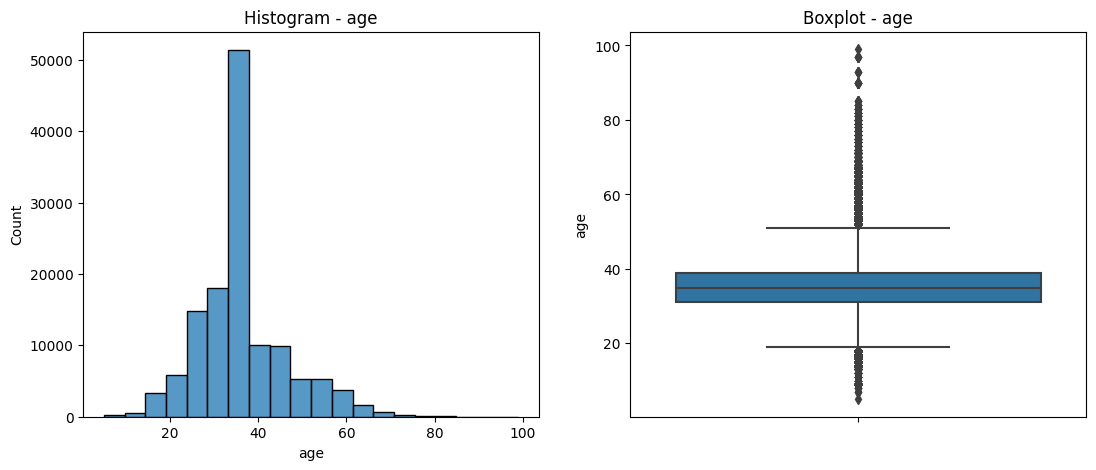

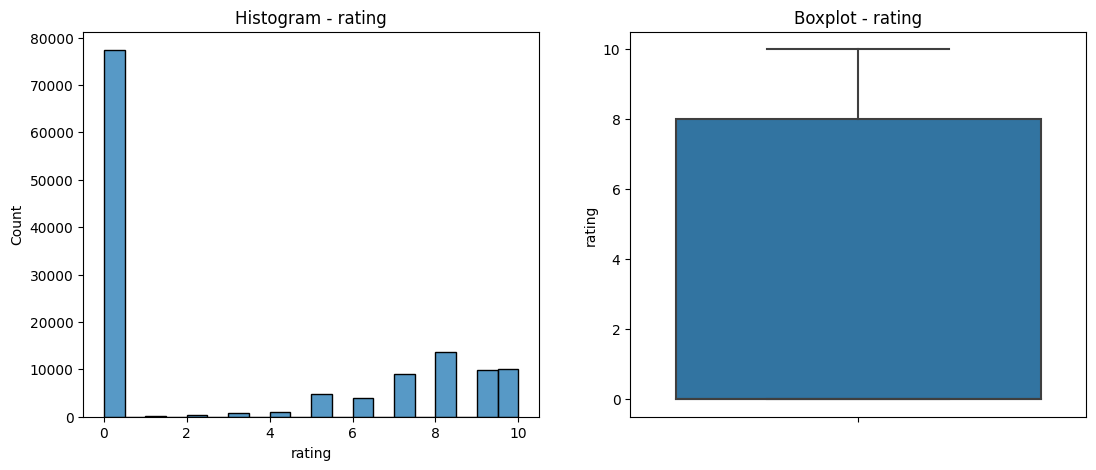

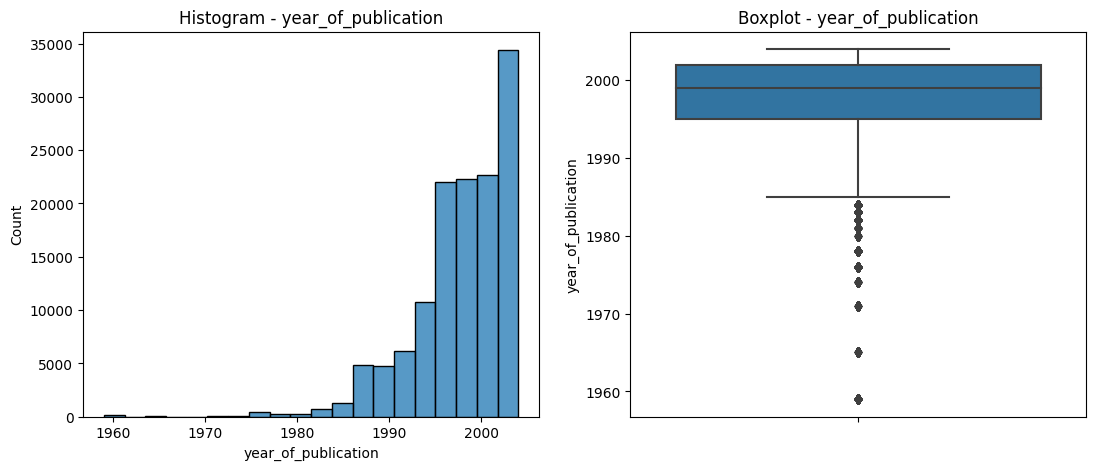

In [71]:
numeric_categorical_variables = ['age', 'rating', 'year_of_publication']

for variable in numeric_categorical_variables:
    plt.figure(figsize=(20, 5))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(train_data[variable], bins=20, )
    plt.title(f'Histogram - {variable}')

    # boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(y=train_data[variable])
    plt.title(f'Boxplot - {variable}')
    titulo = "histogram_" + str(variable) + ".pdf"
    plt.savefig(titulo, format = "pdf", dpi = 300, bbox_inches='tight')
    plt.show()


Podemos identificar a presença de diversos possíveis outliers neste dataset. Utilizemos a tecnica de z-scores para tratar destes dados

Para isso, vamos primeiro esquematizar a regra:

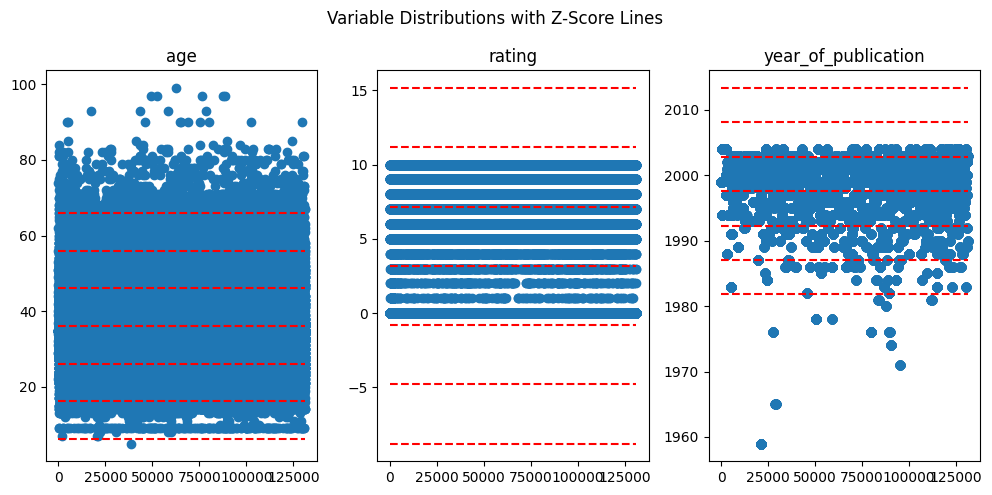

In [72]:
n_std = 3

# Create a figure with subplots for each column
fig, axes = plt.subplots(1, len(numeric_categorical_variables), figsize=(10, 5))

for i, variable in enumerate(numeric_categorical_variables):
    mean = train_data[variable].mean()
    std = train_data[variable].std()

    axes[i].scatter(np.arange(len(train_data[variable])), train_data[variable])
    # Calculate the x values for the lines
    x = np.linspace(train_data[variable].min(), train_data[variable].max(), 100)
    
    # Calculate the y values for the normal distribution
    y = stats.norm.pdf(x, loc=mean, scale=std)
    

    for j in range(-n_std, n_std+1):
        line_x = [0, len(train_data[variable])]
        line_y = [mean + j * std] * 2
        axes[i].plot(line_x, line_y, color='r', linestyle='--')
        
    # Set the title for the subplot
    axes[i].set_title(variable)

# Add a title and show the plot
plt.suptitle('Variable Distributions with Z-Score Lines')
plt.tight_layout()
plt.savefig("z_score.png", format = "png", dpi = 300, bbox_inches='tight')
plt.show()

Podemos observar que mesmo em um range de score z conservador de 3 desvios padrões, ainda estamos lidando com uma massa considerável de 4 desvios padrões, ainda existe uma quantidade considerável de possíveis outliers que devem ser removidos

In [73]:
z_scores = stats.zscore(train_data[numeric_categorical_variables])

# Filter out rows where any of the z-scores are greater than 3 or less than -3
rows_filter = (z_scores < n_std).all(axis=1) & (z_scores > -3).all(axis=1)
train_data = train_data[rows_filter]
train_data

,age,rating,book_author,year_of_publication,publisher,Category,city,state,country
0,34.7439,0,johngrisham,1999,Dell,fiction,germantown,tennessee,usa
1,34.7439,0,johngrisham,1999,Dell,fiction,arden hills,minnesota,usa
2,35.0000,0,johngrisham,1999,Dell,fiction,nashville,tennessee,usa
3,29.0000,0,johngrisham,1999,Dell,fiction,knoxville,tennessee,usa
4,31.0000,0,johngrisham,1999,Dell,fiction,portland,oregon,usa
...,...,...,...,...,...,...,...,...,...
131174,25.0000,0,garyzukav,1990,Free Press,bodymindspirit,daly city,california,usa
131175,62.0000,10,garyzukav,1990,Free Press,bodymindspirit,waldport,oregon,usa
131176,53.0000,8,garyzukav,1990,Free Press,bodymindspirit,boise,idaho,usa
131177,37.0000,0,garyzukav,1990,Free Press,bodymindspirit,longwood,florida,usa


Como utilizaremos algoritmos baseados em árvore, que naturalmente trabalham bem com variáveis categóricas, não há a necessidade de se realizar one-hot encoding das features. E portanto, como medida de economia de memória e redução do tempo de treinamento, utilizaremos uma estratégia de label encoding.

In [74]:
other_variables = list(set(train_data.columns) - set(numeric_categorical_variables))

for variable in other_variables:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
    oe.fit(train_data[[variable]])
    train_data[variable] = oe.transform(train_data[[variable]]).astype(int)
    test_data[variable] = oe.transform(test_data[[variable]]).astype(int)

train_data.head()

,age,rating,book_author,year_of_publication,publisher,Category,city,state,country
0,34.7439,0,175,1999,31,28,2218,5313,3864
1,34.7439,0,175,1999,31,28,216,400,3864
2,35.0000,0,175,1999,31,28,4104,5313,3864
3,29.0000,0,175,1999,31,28,3074,5313,3864
4,31.0000,0,175,1999,31,28,5830,5162,3864


Por fim, vamos, agora, normalizar as variáveis numéricas:

In [75]:
#saved for later use in denormalizing predicted results
mean_values = {} 
std_values = {}

for variable in train_data.drop('rating', axis= 1).columns:
    mean_values[variable] = train_data[variable].mean()
    std_values[variable] = train_data[variable].std()

    train_data.loc[:, variable] = (train_data[variable] - mean_values[variable])/(std_values[variable])
    test_data.loc[:, variable] = (test_data[variable] - mean_values[variable])/(std_values[variable])

train_data.head() 

,age,rating,book_author,year_of_publication,publisher,Category,city,state,country
0,-0.111753,0,-0.175777,0.255234,-0.818487,0.698082,-0.693248,1.411734,0.444013
1,-0.111753,0,-0.175777,0.255234,-0.818487,0.698082,-1.524429,-0.673784,0.444013
2,-0.084589,0,-0.175777,0.255234,-0.818487,0.698082,0.089772,1.411734,0.444013
3,-0.720994,0,-0.175777,0.255234,-0.818487,0.698082,-0.337859,1.411734,0.444013
4,-0.508859,0,-0.175777,0.255234,-0.818487,0.698082,0.806364,1.347636,0.444013


## Decision Tree
Abaixo encontram-se os códigos referentes à criação do modelo de árvore de decisão. 

Separa-se inicialmente o dataset em features e variável alvo.

In [76]:
features = train_data.drop('rating', axis = 'columns', inplace = False)
target = train_data['rating']

entrada = test_data.drop('rating', axis = 'columns', inplace = False)
alvo = test_data['rating']

Após isso, cria-se o modelo de árvore de decisão com os dados de treinamento. A qualidade do ganho de informação para os nós foi feita pelo critério de Gini, que é o padrão desse método. A profundidade máxima da árvore foi escolhida como sendo 8, devido à quantidade de features. Por fim, retorna-se a acurácia média do modelo com os dados de teste. 

In [77]:
modelo_inicial = tree.DecisionTreeClassifier(criterion='gini', max_depth=8)

modelo_inicial.fit(features, target)
modelo_inicial.score(entrada, alvo)

0.5899984753773441

A fim de se melhorar a escolha do modelo da árvore de decisão, foi feita uma busca matricial (grid search), procurando ajustar melhor os parâmetros de critério de ganho de informação e de profundidade máxima.

In [78]:
# Grid search
modelo = tree.DecisionTreeClassifier()

search_space = {"criterion": ["gini", "entropy", "log_loss"],
                "max_depth": np.arange(1, 45, 1, dtype=int)
                }

grid = GridSearchCV(estimator = modelo, 
                    param_grid = search_space,
                    n_jobs=-1,
                    verbose = 4)

grid.fit(features, target)

Fitting 5 folds for each of 132 candidates, totalling 660 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44])},
             verbose=4)

Esses são os resultados encontrados pela grid search:

In [79]:
grid.best_score_, grid.best_params_

(0.5908529431341548, {'criterion': 'gini', 'max_depth': 1})

Testando os parâmetros encontrados pela grid search nos dados de teste, obtém-se a seguinte acurácia média:

In [80]:
# Aplicando o modelo de arvore de decisao escolhido aos dados de teste
modelo_gs = tree.DecisionTreeClassifier(criterion= grid.best_params_['criterion'],
                                     max_depth= grid.best_params_['max_depth'])
modelo_gs.fit(features, target)
modelo_gs.score(entrada, alvo)

0.589815520658637

## KNN

Par discussão no trabalho, apenas a árvore de decisão será levada em conta. O método de KNN foi feito apenas para fins de aprendizado da dupla.

Grid search nesse caso foi feito antes mesmo de escolher os parâmetros baseado na intuição.

In [81]:
knn = KNeighborsClassifier()

# Grid search para ajuste de hiperparâmetros do KNN
search_space = {"n_neighbors": [2*i + 1 for i in range(10)],
                "weights": ['uniform', 'distance'],
                "p": [1,2,3]
                }

grid = GridSearchCV(estimator = knn,
                    param_grid= search_space,
                    scoring= "accuracy",
                    return_train_score=False,
                    verbose=4,
                    n_jobs= -1
                    )
    
grid.fit(features, target)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'p': [1, 2, 3], 'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=4)

Esses são os resultados encontrados pela grid search:

In [82]:
# Vendo a acuracia e os parametros escolhidos
grid.best_score_, grid.best_params_

(0.5869529929114546, {'n_neighbors': 19, 'p': 3, 'weights': 'uniform'})

Testando os parâmetros encontrados pela grid search nos dados de teste, obtém-se a seguinte acurácia média:

In [83]:
# Aplicando o modelo de knn escolhido aos dados de teste
knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'],
                            p = grid.best_params_['p'], 
                            weights= grid.best_params_['weights'])
knn.fit(features, target)
knn.score(entrada, alvo)

0.5875590791279158

## Classificador a priori
Scripts para construção de classificador a priori (zero regra)

Agora, utiliza-se o método de grid search para escolher qual a estratégia de classificação para o classificador a priori e, se for o caso de classificação constante, qual a constante será considerada para isso.

In [84]:
zero_regra = DummyClassifier()
search_space = {"strategy": ["most_frequent", "prior", "stratified", "uniform", "constant"],
                "constant": np.arange(0,11,1, dtype=int)
                }

grid = GridSearchCV(estimator = zero_regra,
                    param_grid= search_space,
                    scoring= "accuracy",
                    return_train_score=False,
                    verbose=4,
                    n_jobs= -1
                    )
grid.fit(features, target)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


GridSearchCV(estimator=DummyClassifier(), n_jobs=-1,
             param_grid={'constant': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'strategy': ['most_frequent', 'prior', 'stratified',
                                      'uniform', 'constant']},
             scoring='accuracy', verbose=4)

Esses são os resultados encontrados pela grid search:

In [85]:
grid.best_params_, grid.best_score_

({'constant': 0, 'strategy': 'most_frequent'}, 0.5908529431341548)

Testando os parâmetros encontrados pela grid search nos dados de teste, obtém-se a seguinte acurácia média:

In [86]:
zero_regra = DummyClassifier(strategy= grid.best_params_['strategy'], 
                             constant=grid.best_params_['constant'])

zero_regra.fit(features, target)
zero_regra.score(entrada, alvo)

0.589815520658637

## Análise de performance dos modelos
Scripts para comparar eficiência e resultado dos diferentes modelos construidos (KNN/Decision Tree vs. Priori classifier). 

In [87]:
desempenho = [] # acuracia, precisao, recall

## Zero regra 
# Teste
predicao = zero_regra.predict(entrada)
acuracia = accuracy_score(alvo, predicao)
precisao, recall = precision_recall_fscore_support(alvo, predicao, average='macro', zero_division= 0)[0:2]
desempenho.append([acuracia, precisao, recall])

# Treinamento
predicao = zero_regra.predict(features)
acuracia = accuracy_score(target, predicao)
precisao, recall = precision_recall_fscore_support(target, predicao, average='macro', zero_division= 0)[0:2]
desempenho.append([acuracia, precisao, recall])

## Arvore de decisao 
# Teste 
predicao = modelo_inicial.predict(entrada)
acuracia = accuracy_score(alvo, predicao)
precisao, recall = precision_recall_fscore_support(alvo, predicao, average='macro', zero_division= 0)[0:2]
desempenho.append([acuracia, precisao, recall])

# Treinamento 
predicao = modelo_inicial.predict(features)
acuracia = accuracy_score(target, predicao)
precisao, recall = precision_recall_fscore_support(target, predicao, average='macro', zero_division= 0)[0:2]
desempenho.append([acuracia, precisao, recall])

print(desempenho)

[[0.589815520658637, 0.05361959278714881, 0.09090909090909091], [0.5908529432329338, 0.05371390393026671, 0.09090909090909091], [0.5899984753773441, 0.2628157574565784, 0.09510223519593981], [0.5937818037741126, 0.45877304941226354, 0.09621984169184174]]
